In [1]:
%cd '/mnt/c/Users/malin/Documents/Facultate/honours/UMCG/ICU_Augment_and_Detect'

/mnt/c/Users/malin/Documents/Facultate/honours/UMCG/ICU_Augment_and_Detect


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import cv2
import os
import sys
import numpy as np
import random
import pydot 

sys.path.append(os.getcwd())

from categorization.cnn import make_model, load_data, load_data_eyes, save_history

In [3]:
def load_all_models(save_path, features):
	all_models = list()
	for feature in features:
		filename = save_path + str(feature) + '/save.h5'
		model = tf.keras.models.load_model(filename)
		all_models.append(model)
		print('loaded model of ' + str(feature))
	return all_models

def define_stacked_model(neural_nets, features):
	for model in neural_nets:
		for layer in model.layers:
			layer.trainable = False

	ensemble_visible = [model.input for model in neural_nets]
	ensemble_outputs = [model.layers[27].output for model in neural_nets]

	merge = tf.keras.layers.concatenate(ensemble_outputs)
	hidden = tf.keras.layers.Dense(10, activation='relu')(merge)
	output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)
	model = tf.keras.Model(inputs=ensemble_visible, outputs=output)

	plot_model(model, show_shapes=True, to_file='data/plots/model_graph.png')
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
	return model

def make_training_sets(face_features, image_folder_sick, image_folder_healthy, image_size):
    train_sets_images = []
    train_sets_labels = []
    for feature in face_features:
        print("[INFO] loading %s" %(feature))
        if feature == "eyes":
            train_images, train_labels = load_data_eyes(image_folder_sick, image_folder_healthy, image_size)
            size = int(len(train_images)/2)
            train_images = train_images[:size]
            train_sets_labels.append(train_labels[:size])
        else:
            train_images, train_labels = load_data(image_folder_sick, image_folder_healthy, image_size, feature)
        train_sets_images.append(train_images)
    
    return train_sets_images, train_sets_labels


In [4]:
if __name__ == "__main__":

    save_path = 'categorization/model_saves/'
    image_folder_sick = 'data/parsed/sick'
    image_folder_healthy = 'data/parsed/healthy'
    face_features = ["mouth", "face", "skin", "eyes"]
    image_size = 217

    # all_models = load_all_models(save_path, face_features)

    # train_sets_images, train_sets_labels = make_training_sets(face_features, image_folder_sick, image_folder_healthy, image_size)

    # stacked = define_stacked_model(all_models, face_features)
    # history = stacked.fit(train_sets_images, train_sets_labels, epochs=100, verbose=0)


In [7]:
def make_training_sets(face_features, image_folder_sick, image_folder_healthy, image_size):

    train_images_mouth, train_labels = load_data(
        image_folder_sick, image_folder_healthy, image_size, "mouth")
    train_images_face, train_labels = load_data(
        image_folder_sick, image_folder_healthy, image_size, "face")
    train_images_skin, train_labels = load_data(
        image_folder_sick, image_folder_healthy, image_size, "skin")
    train_images_right_eye, train_labels = load_data(
        image_folder_sick, image_folder_healthy, image_size, "right")

    test_images_mouth = np.concatenate([train_images_mouth[:3], train_images_mouth[len(train_images_mouth)-3:]])
    test_images_face = np.concatenate([train_images_face[:3], train_images_mouth[len(train_images_face)-3:]])
    test_images_skin = np.concatenate([train_images_skin[:3], train_images_mouth[len(train_images_skin)-3:]])
    test_images_eyes = np.concatenate([train_images_right_eye[:3], train_images_mouth[len(train_images_right_eye)-3:]])
    test_labels = np.concatenate([train_labels[:3], train_labels[len(train_labels)-3:]])

    perm1 = np.random.permutation(6)
    test_images = [test_images_mouth[perm1], test_images_face[perm1], test_images_skin[perm1], test_images_eyes[perm1]]
    test_labels = test_labels[perm1]

    perm2 = np.random.permutation(len(train_labels)-6)

    train_images_mouth = train_images_mouth[3:len(train_images_mouth)-3]
    train_images_face = train_images_face[3:len(train_images_face)-3]
    train_images_skin = train_images_skin[3:len(train_images_skin)-3]
    train_images_eyes = train_images_right_eye[3:len(train_images_right_eye)-3]

    train_images = [train_images_mouth[perm2], train_images_face[perm2],
                    train_images_skin[perm2], train_images_eyes[perm2]]

    train_labels = train_labels[perm2]

    return train_images, train_labels, test_images, test_labels

In [11]:
 train_images, train_labels, test_images, test_labels = make_training_sets(face_features, image_folder_sick, image_folder_healthy, image_size)

In [12]:
print(test_labels)
print(len(train_labels))

[0 1 0 1 1 0]
46


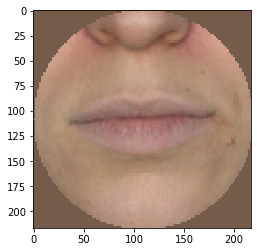

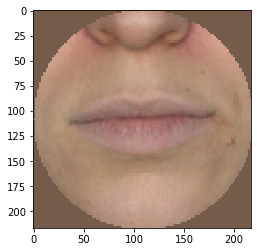

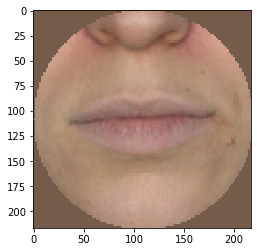

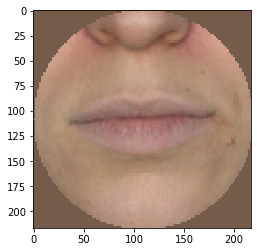

In [24]:
plt.imshow(test_images[0][3])
plt.figure()
plt.imshow(test_images[1][3])
plt.figure()
plt.imshow(test_images[2][3])
plt.figure()
plt.imshow(test_images[3][3])